# ทดสอบกระบวนการสร้างแบบจำลอง Regression ด้วย ML จาก Github Microsoft
https://github.com/MicrosoftDocs/ml-basics/blob/master/02%20-%20Regression.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# read & data cleansing

In [2]:
df = pd.read_csv('./00Results/df_org_dbz_rain_test200km_full_features.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## explore data

In [3]:
df.describe()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,rain_truth
count,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000
mean,28.312452,28.417807,28.421282,28.115109,2.170921
std,7.981244,7.883439,7.810217,7.769884,4.443954
min,1.553552,1.187277,-1.999605,-4.499764,0.100000
25%,22.931310,23.175378,23.352370,23.290597,0.200000
50%,27.599644,27.829594,27.965809,27.917465,0.600000
75%,33.327730,33.424530,33.544266,33.251520,2.000000
max,57.279980,57.279980,57.279976,57.243618,72.000000


ดูค่าสถิติของข้อมูลในแต่ละตัวแปร

### histograms and box plots ของฝนที่ใช้เป็น label

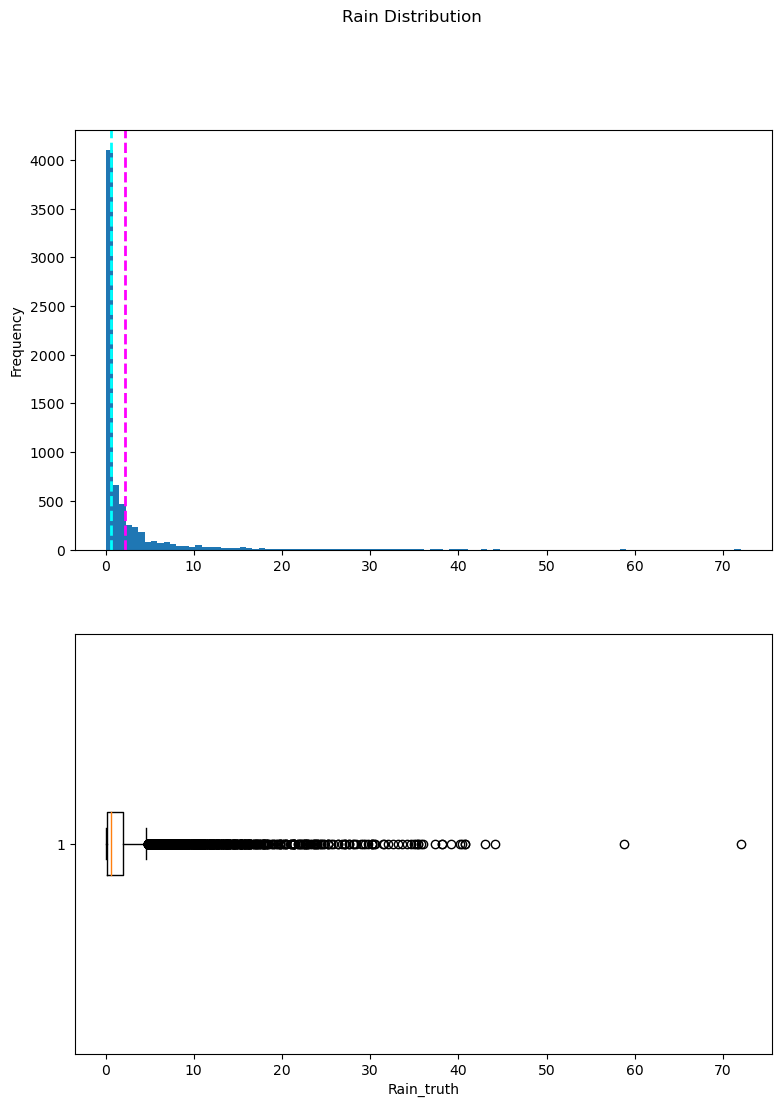

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column
label = df['rain_truth']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rain_truth')

# Add a title to the Figure
fig.suptitle('Rain Distribution')

# Show the figure
fig.show()

In [5]:
print(label.mean())
print(label.median())

2.1709207199167038
0.6


ค่าฮิสโตแกรมของฝนภาคพื้นดิน มีค่าฝนเฉลียอยู่ที่ 2.17 mm/hr ในขณะที่ค่ามัธยฐานอยู่ที่ 0.6 mm/hr ส่วน boxplot แสดงถึงค่า outliers ที่มีจำนวนน้อยแสดงด้วยวงกลมที่มีค่าห่างจากค่าเฉลี่ย

### histograms ของฟีเจอร์อื่น


In [6]:
list(df.columns)

['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_intensity', 'rain_truth']

In [7]:
numeric_features = list(df.drop(columns=['rain_intensity', 'rain_truth']))
#numeric_features

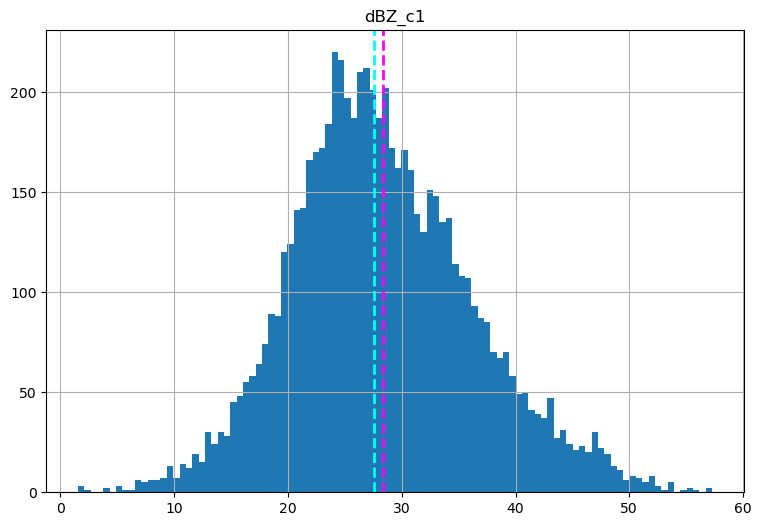

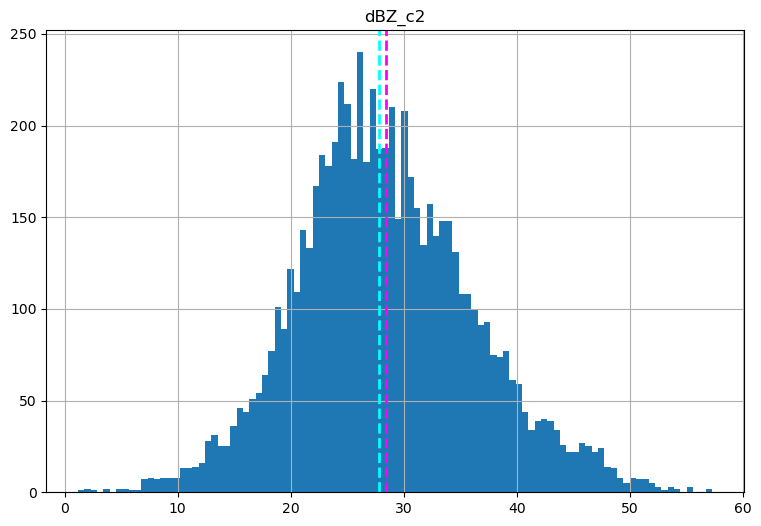

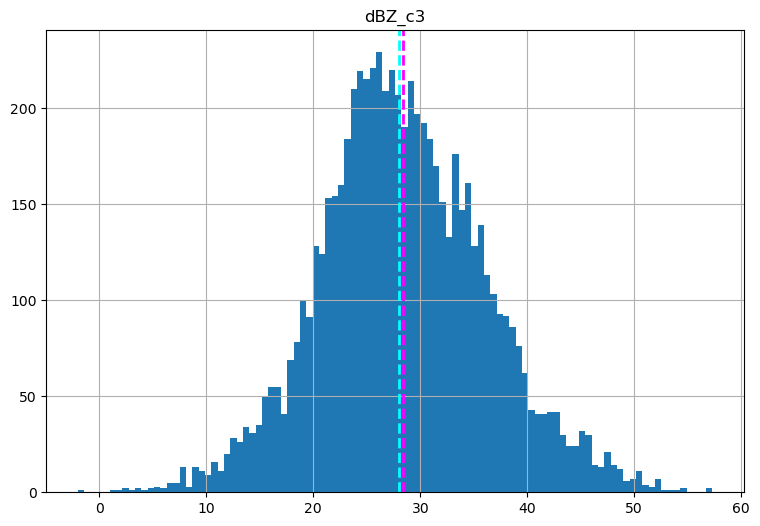

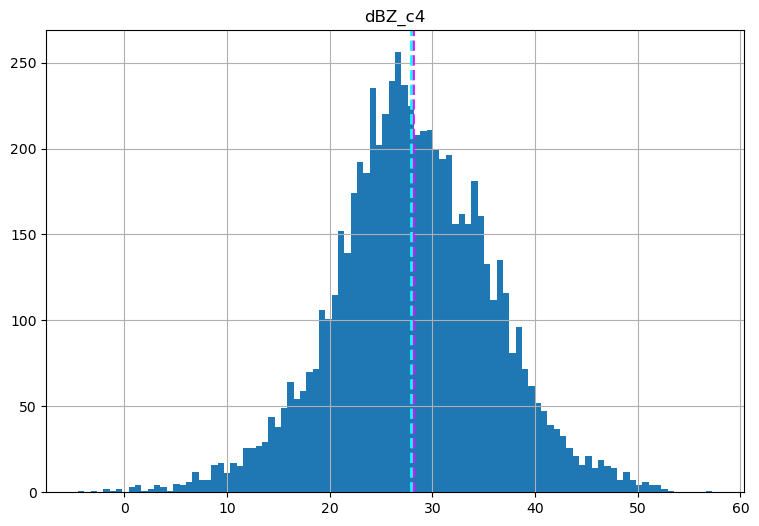

In [8]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

ค่า dbz มีการกระจายตัวแบบโค้งระฆังคว่ำ ที่มีค่าเฉลี่ยอยู่ตรงกลาง 

### histogram ของ rain_intensity ที่เป็นชนิด categorical features

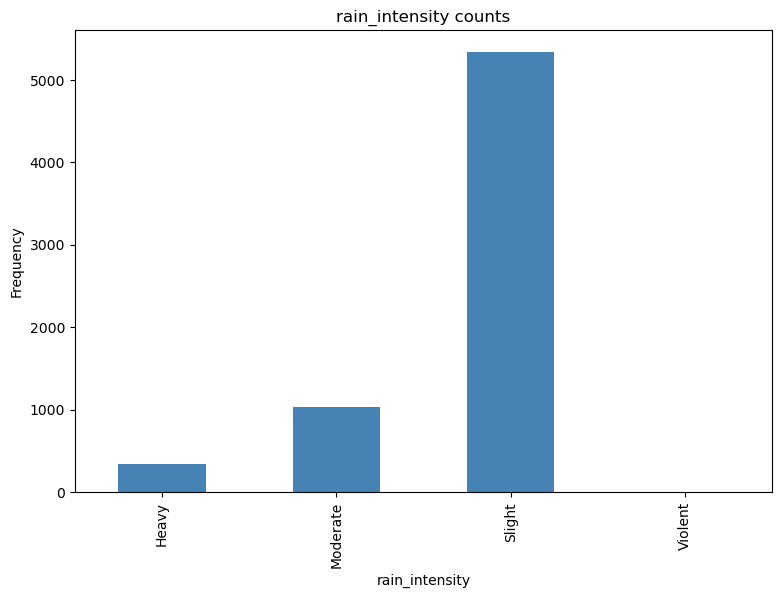

In [9]:
categorical_features = ['rain_intensity']
for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

ฝนอ่อนมีจำนวนความถี่มากสุด ในขณะที่ฝนหนักมีน้อยกว่า 10 เรคคอร์ด

### พลอต scatter diagram ระหว่างฟีเจอร์กับฝนสสน.

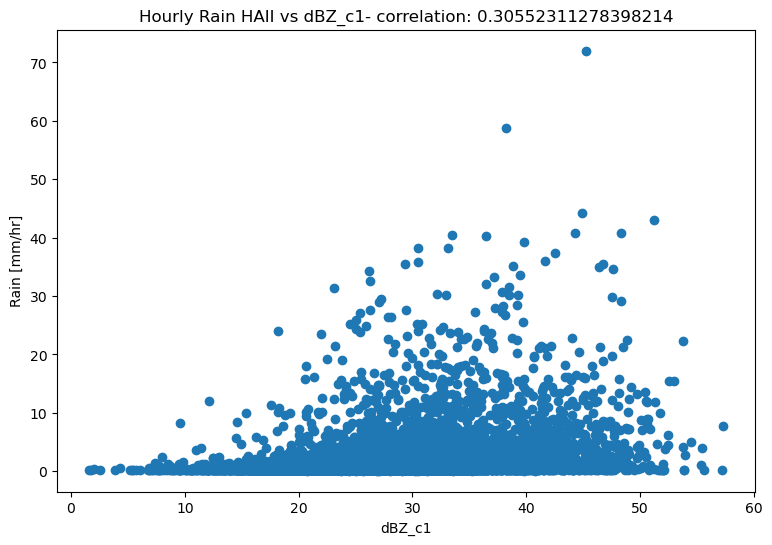

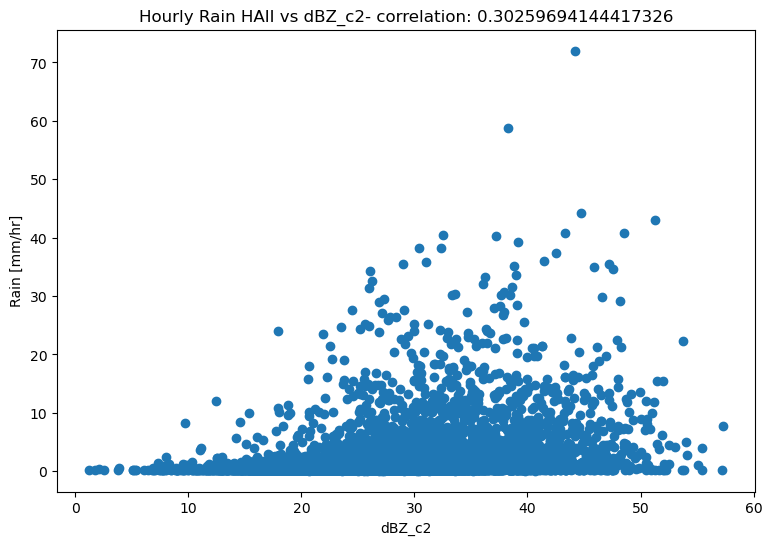

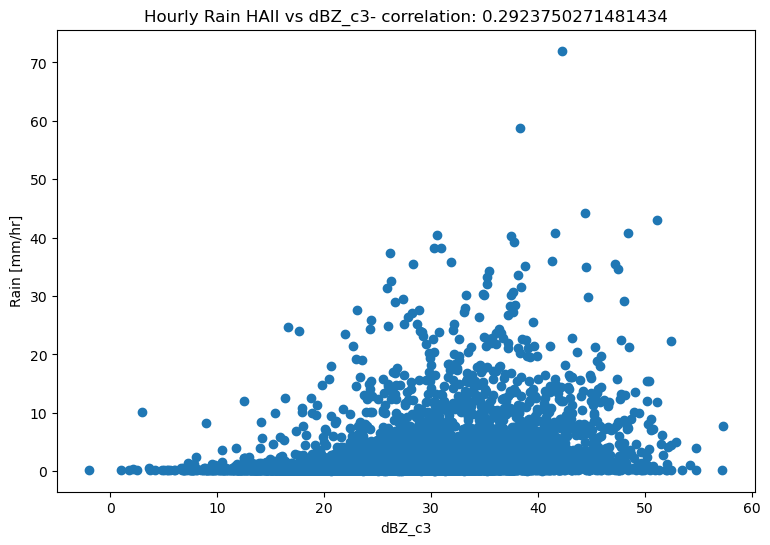

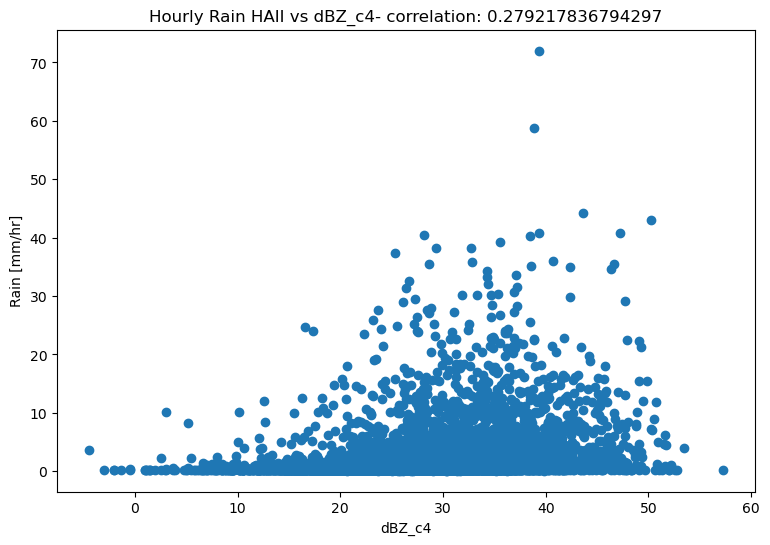

In [10]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['rain_truth']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Rain [mm/hr]')
    ax.set_title('Hourly Rain HAII vs ' + col + '- correlation: ' + str(correlation))
plt.show()

ค่าความสัมพันธ์ระหว่างฝนกับตัวแปรอื่น มีความสอดคล้องกันอย่างอ่อน ๆ โดยเฉพาะมุมยกด้านล่าง อย่างไรก็ดีสามารถใช้ pairplot และ correlation matrix ช่วยในการแปลผลได้

### boxplot ของ rain intensity

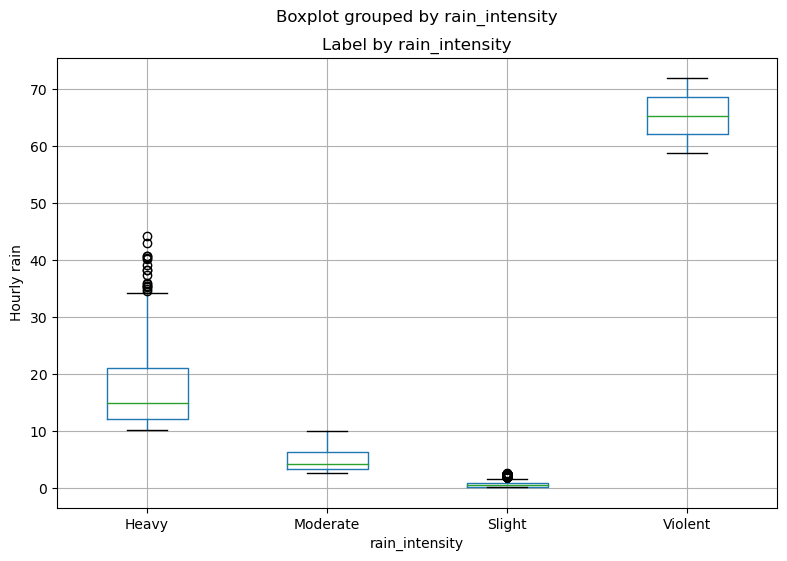

In [11]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column = 'rain_truth', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Hourly rain")
plt.show()

ฝนอ่อนมีค่ากระจายตัว outlier ค่อนข้างมาก ส่วน moderate มีค่าที่ค่อนข้างเกาะกลุ่ม ในขณะที่ฝนหนักมีข้อมูลน้อยเกินไป

## Train a Regression Model

###  linear regression

In [12]:
df.columns

Index(['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_intensity', 'rain_truth'], dtype='object')

In [13]:
# Step 2: Defining the columns and reading the DataFrame 
TargetVariable=['rain_truth']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4', 
#            'rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_p1', 'rr_MP_p2', 'rr_MP_p3', 'rr_MP_p4', 
#            'rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4', 
#            'rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4', 'rr_SC_p1', 'rr_SC_p2', 'rr_SC_p3', 'rr_SC_p4'] # แบบจำลองไม่ดี 

#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_p1', 'dBZ_p2',  
#            'rr_MP_c1', 'rr_MP_c2', 'rr_MP_p1', 'rr_MP_p2',
#            'rr_RF_c1', 'rr_RF_c2', 'rr_RF_p1', 'rr_RF_p2',
#            'rr_SC_c1', 'rr_SC_c2', 'rr_SC_p1', 'rr_SC_p2']  # แบบจำลองไม่ดี 

Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4'] # แบบจำลองดี
#Predictors=['dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4'] # แบบจำลองไม่ดีน้อยกว่า cappi ล้วน
#Predictors=['dBZ_c1', 'dBZ_c2','dBZ_p1', 'dBZ_p2'] # แบบจำลองค่อนข้างดี 
#Predictors=['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4'] # แบบจำลองไม่ดี 
#Predictors=['dBZ_c1', 'dBZ_p1'] 

# Step 3: Seperating the data into features and labels
X=df[Predictors].values
y=df[TargetVariable].values

In [14]:
# ปรับ scale ข้อมูล
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# fit and transform the data
#X = scaler.fit_transform(X)


In [15]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 4706 rows
Test Set: 2017 rows


In [16]:
# เทรน model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


In [17]:
# ประเมินแบบจำลอง
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [[ 3.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 2.]
 [-0.]
 [ 4.]]
Actual labels   :  [[6.6]
 [1. ]
 [0.2]
 [2. ]
 [2.8]
 [0.4]
 [6. ]
 [0.6]
 [0.2]
 [7. ]]


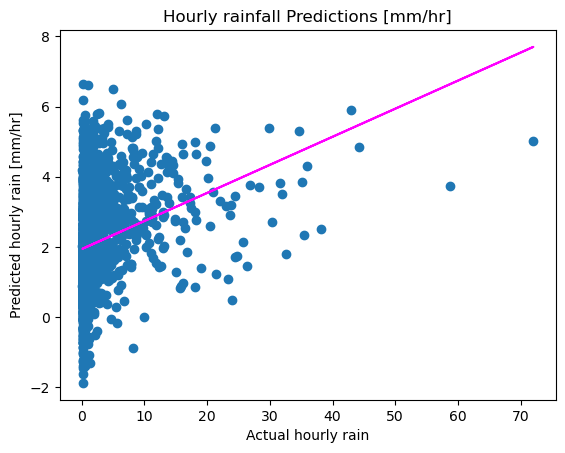

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [19]:
### พลอต density

In [20]:
def density_plot(y_test,predictions):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # data
    x=y_test.transpose().flatten()
    y=predictions.flatten()

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50,cmap='jet')

    plt.xlabel('Actual hourly rain')
    plt.ylabel('Predicted hourly rain [mm/hr]')
    plt.title('Hourly rainfall Predictions [mm/hr]')
    z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
    p = np.poly1d(z)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='magenta', linewidth=2)
    #plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

In [21]:
y_test.transpose().flatten().shape

(2017,)

In [22]:
predictions.flatten().shape

(2017,)

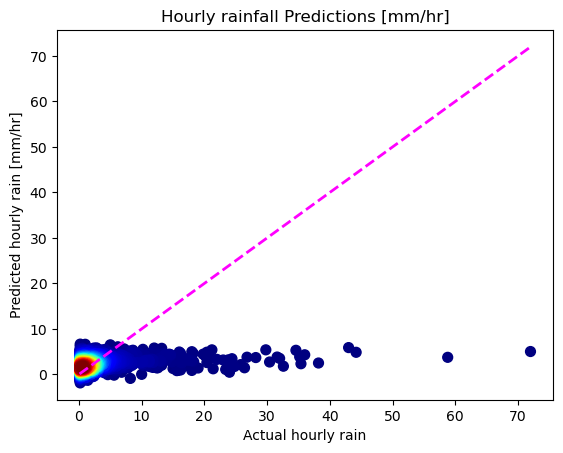

In [23]:
density_plot(y_test,predictions)

แบบจำลองที่ได้ยังไม่ดีหากใส่ตัวแปรทั้งหมด เพราะยังขาดหลายกระบวนการ เช่น การทำให้เป็น scale เดียวกัน การหา feature important หรือการเลือกแบบจำลอง

### การวัดประสิทธิภาพแบบจำลองด้วย metric

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 22.0565673733026
RMSE: 4.696441990837596
R2: 0.08663934607710555


เมื่อนำตัวแปรทั้งหมดใส่ในแบบจำลอง จะพบว่าค่า metric สูงมาก แสดงว่าแบบจำลองไม่ fit ในขณะที่ถ้าเปลี่ยนเป็น cappi อย่างเดียว แบบจำลองดีขึ้นมาก

## ทดสอบหลายๆอัลกอริทึ่ม

### Linear Algorithm  Lasso 

Lasso() 

MSE: 22.10899550007489
RMSE: 4.7020203636388995
R2: 0.084468301628428


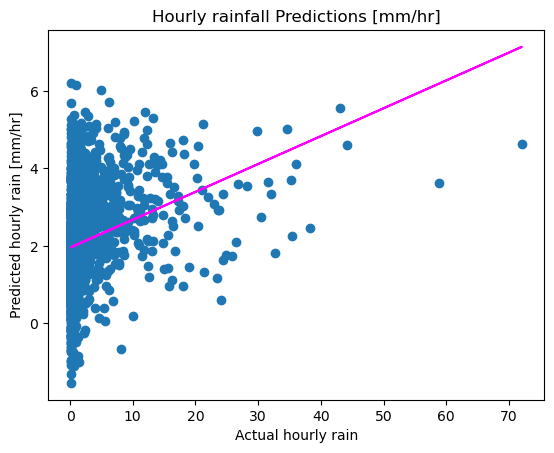

In [25]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

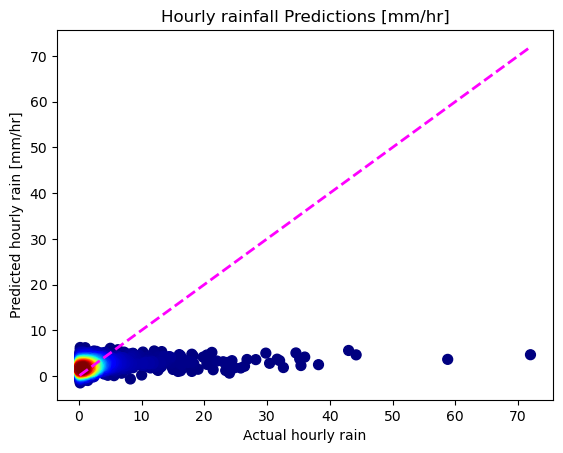

In [26]:
density_plot(y_test,predictions)

### Decision Tree Algorithm

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Visualize the model tree
tree = export_text(model)
print(tree)

DecisionTreeRegressor() 

|--- feature_0 <= 30.38
|   |--- feature_1 <= 25.11
|   |   |--- feature_0 <= 26.21
|   |   |   |--- feature_2 <= 22.39
|   |   |   |   |--- feature_1 <= 17.68
|   |   |   |   |   |--- feature_3 <= -3.75
|   |   |   |   |   |   |--- value: [3.60]
|   |   |   |   |   |--- feature_3 >  -3.75
|   |   |   |   |   |   |--- feature_3 <= 15.67
|   |   |   |   |   |   |   |--- feature_3 <= 12.24
|   |   |   |   |   |   |   |   |--- feature_3 <= 2.52
|   |   |   |   |   |   |   |   |   |--- feature_1 <= 2.30
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 1.97
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  1.97
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.40]
|   |   |   |   |   |   |   |   |   |--- feature_1 >  2.30
|   |   |   |   |   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |   |   |   |   |--- feature_3 >  2.52
|   |   |   |   |   |   |   |   |   |--- fea

MSE: 37.45823996033713
RMSE: 6.1203137142091935
R2: -0.5511426581447887


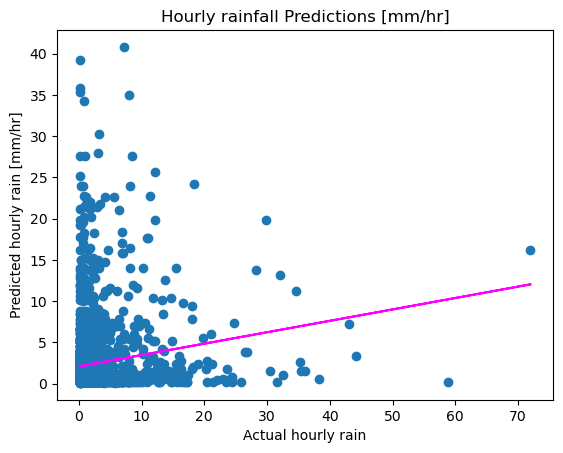

In [28]:
# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

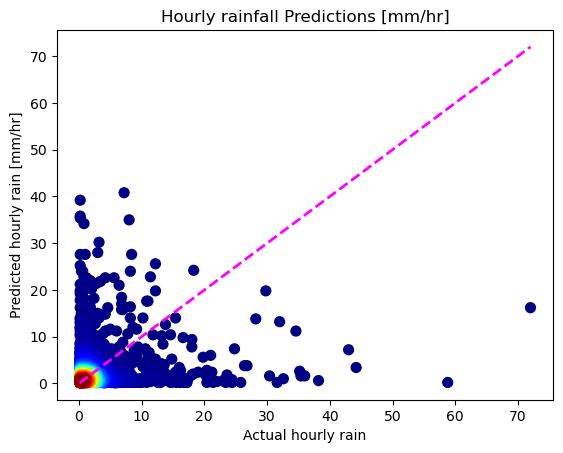

In [29]:
density_plot(y_test,predictions)

### Ensemble Algorithm : Random Forest model

RandomForestRegressor() 

MSE: 23.786474915514788
RMSE: 4.877137984055278
R2: 0.01500401600786061


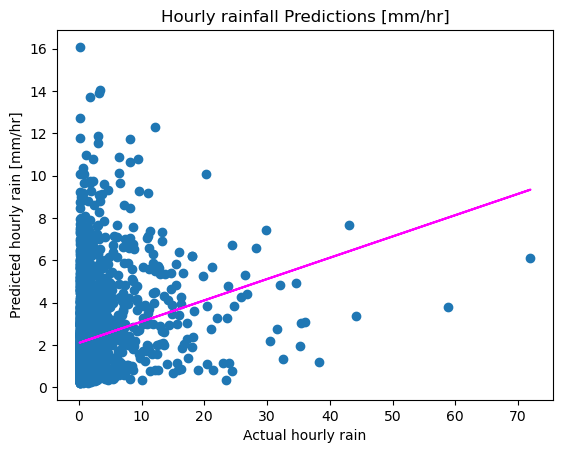

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

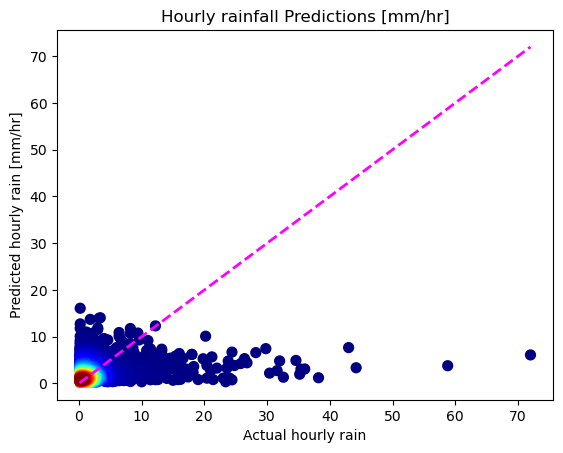

In [31]:
density_plot(y_test,predictions)

### Ensemble Algorithm: GradientBoostingRegressor

GradientBoostingRegressor() 

MSE: 22.431985173877383
RMSE: 4.736241671819269
R2: 0.07109332560964532


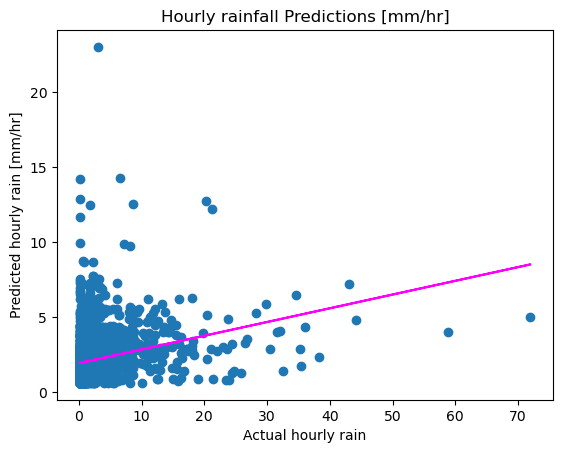

In [32]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor

# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

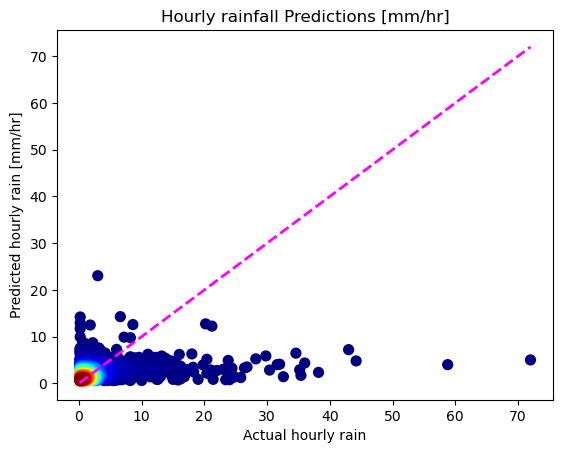

In [33]:
density_plot(y_test,predictions)

## Optimize Hyperparameters

### grid search approach

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 

MSE: 22.100312084133627
RMSE: 4.701096902227567
R2: 0.08482788117352069


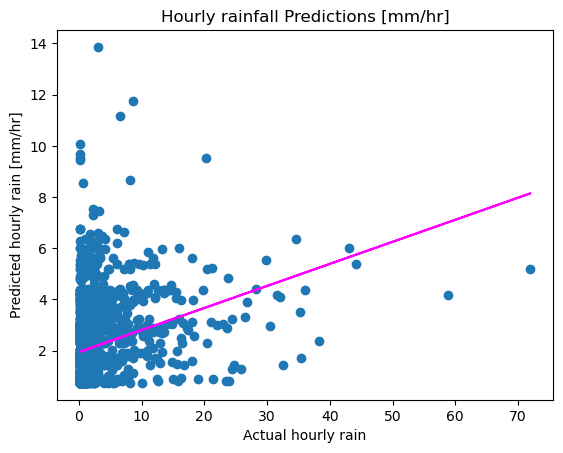

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

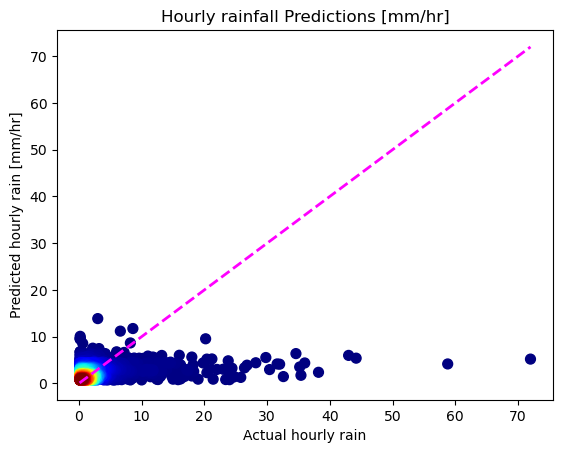

In [35]:
density_plot(y_test,predictions)

## Preprocess the Data StandardScaler

In [36]:
df.columns

Index(['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_intensity', 'rain_truth'], dtype='object')

In [37]:
TargetVariable=['rain_truth']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4', 
#            'rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_p1', 'rr_MP_p2', 'rr_MP_p3', 'rr_MP_p4', 
#            'rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4', 
#            'rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4', 'rr_SC_p1', 'rr_SC_p2', 'rr_SC_p3', 'rr_SC_p4']

Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4'] # แบบจำลองดี
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4','rain_intensity'] # แบบจำลองดี
#Predictors=['dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4'] # แบบจำลองไม่ดีน้อยกว่า cappi ล้วน
#Predictors=['dBZ_c1', 'dBZ_c2','dBZ_p1', 'dBZ_p2'] # แบบจำลองค่อนข้างดี 
#Predictors=['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4'] # แบบจำลองไม่ดี 
#Predictors=['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4'] # แบบจำลองไม่ดี 
#Predictors=['dBZ_c1', 'dBZ_p1'] 

# Step 3: Seperating the data into features and labels
X=df[Predictors].values
y=df[TargetVariable].values

# แยกข้อมูล
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))


Training Set: 4706 rows
Test Set: 2017 rows


### Train the model : GradientBoostingRegressor

In [38]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,2,3]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
#categorical_features = [4]
#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])#,
        #('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', GradientBoostingRegressor())])


### Get predictions

MSE: 22.43324826043202
RMSE: 4.736375012647544
R2: 0.07104102129855383


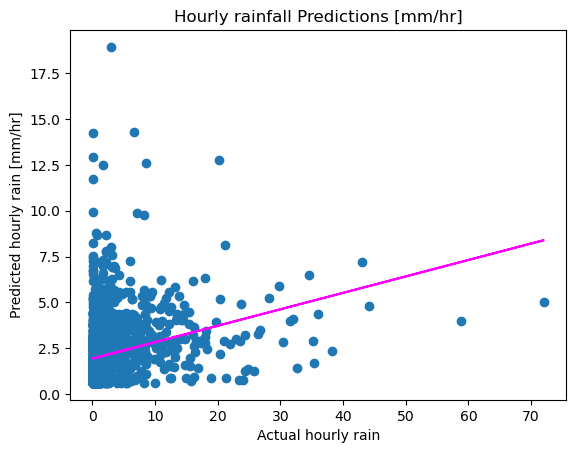

In [39]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

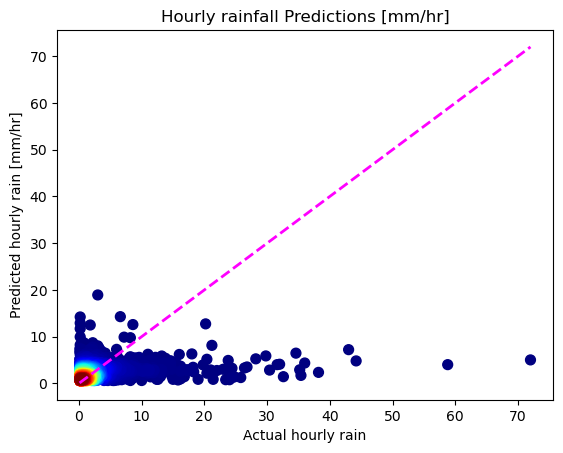

In [40]:
density_plot(y_test,predictions)

###  try Train the model : RandomForestRegressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', RandomForestRegressor())]) 

MSE: 23.53906808607749
RMSE: 4.851707749450443
R2: 0.025249112613117464


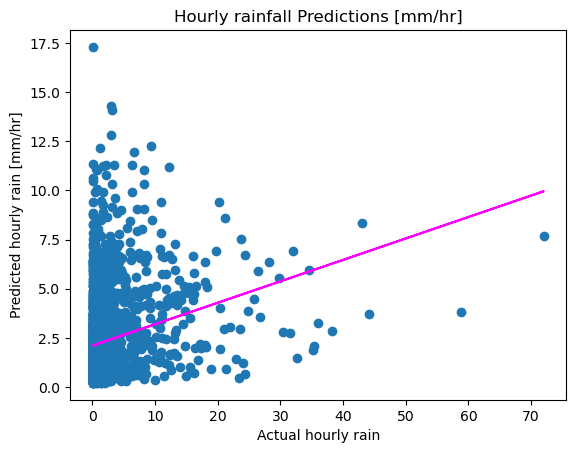

In [41]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## พลอต density map

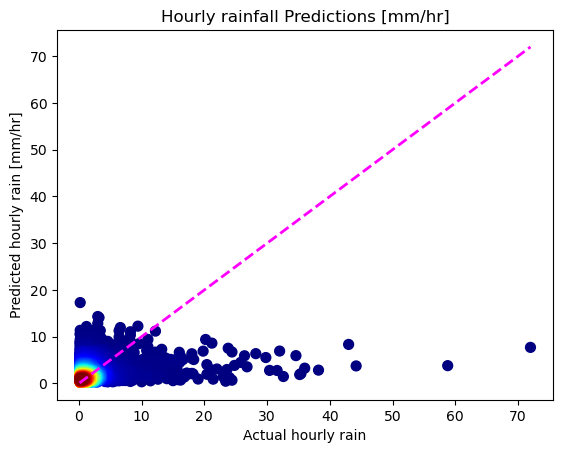

In [42]:
density_plot(y_test,predictions)

## Use the Trained Model

In [43]:
import joblib

# Save the model as a pickle file
filename = './00Results/00models/rain_hour1.pkl'
joblib.dump(model, filename)

['./00Results/00models/rain_hour1.pkl']

In [44]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[10,20,30,25]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} hourly rain'.format(np.round(result[0])))

New sample: [10.0, 20.0, 30.0, 25.0]
Prediction: 3 hourly rain


#### predict หลายอินพุธ


In [45]:
# An array of features based on five-day weather forecast
X_new = np.array([[20,25,30,35],
                  [22,25,35,45],
                  [23,28,37,35],
                  [21,20,30,15],
                  [10,15,30,35]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-predictions:')
for prediction in results:
    print(np.round(prediction))

5-predictions:
3.0
4.0
10.0
3.0
2.0


# Next Try ใน colab
## DL ANN
https://www.kaggle.com/code/abrahamanderson/artificial-neural-networks-for-regression
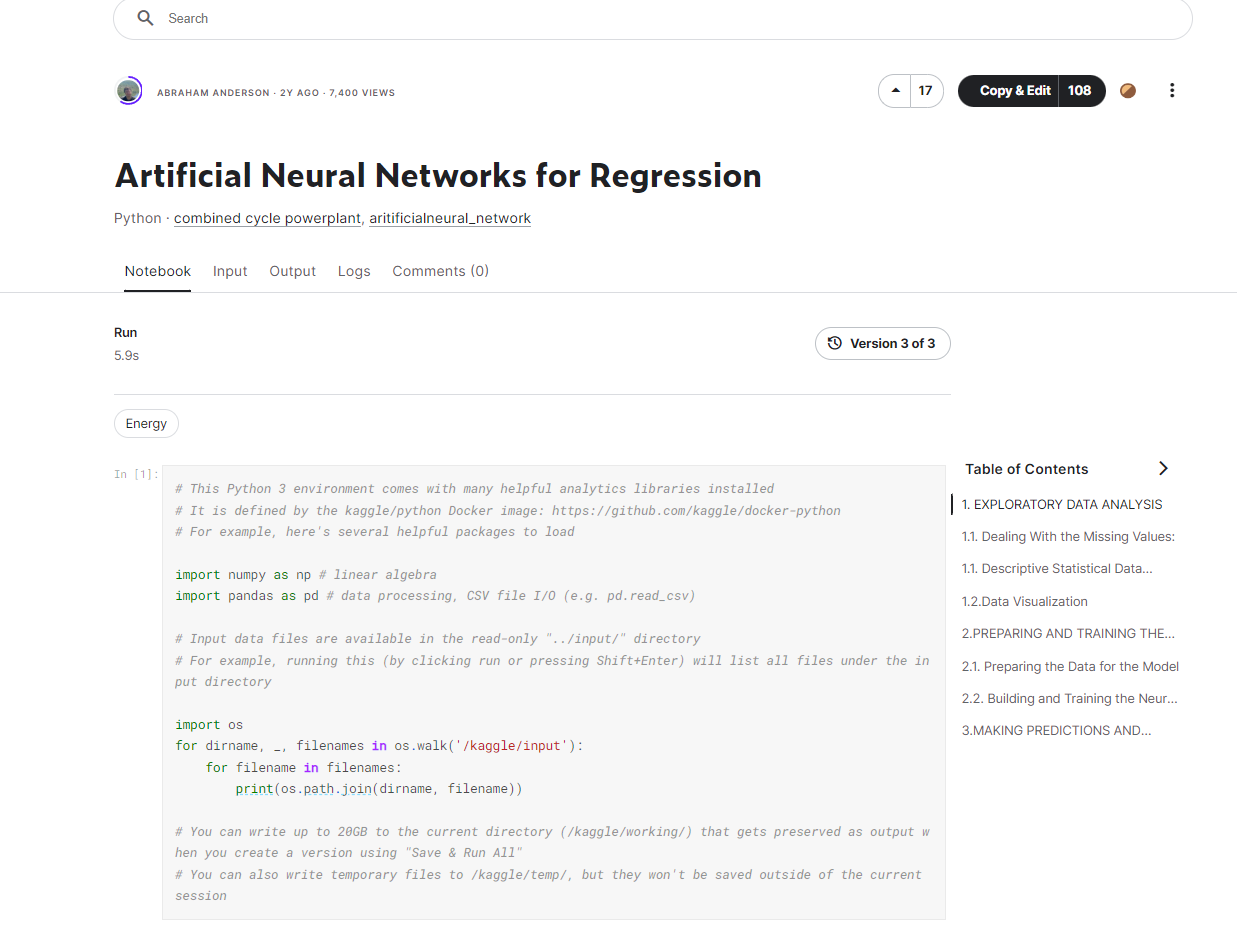

## ทดสอบ ML 
https://www.kaggle.com/code/venkatkrishnan/regression-model-on-multicollinary-dataset

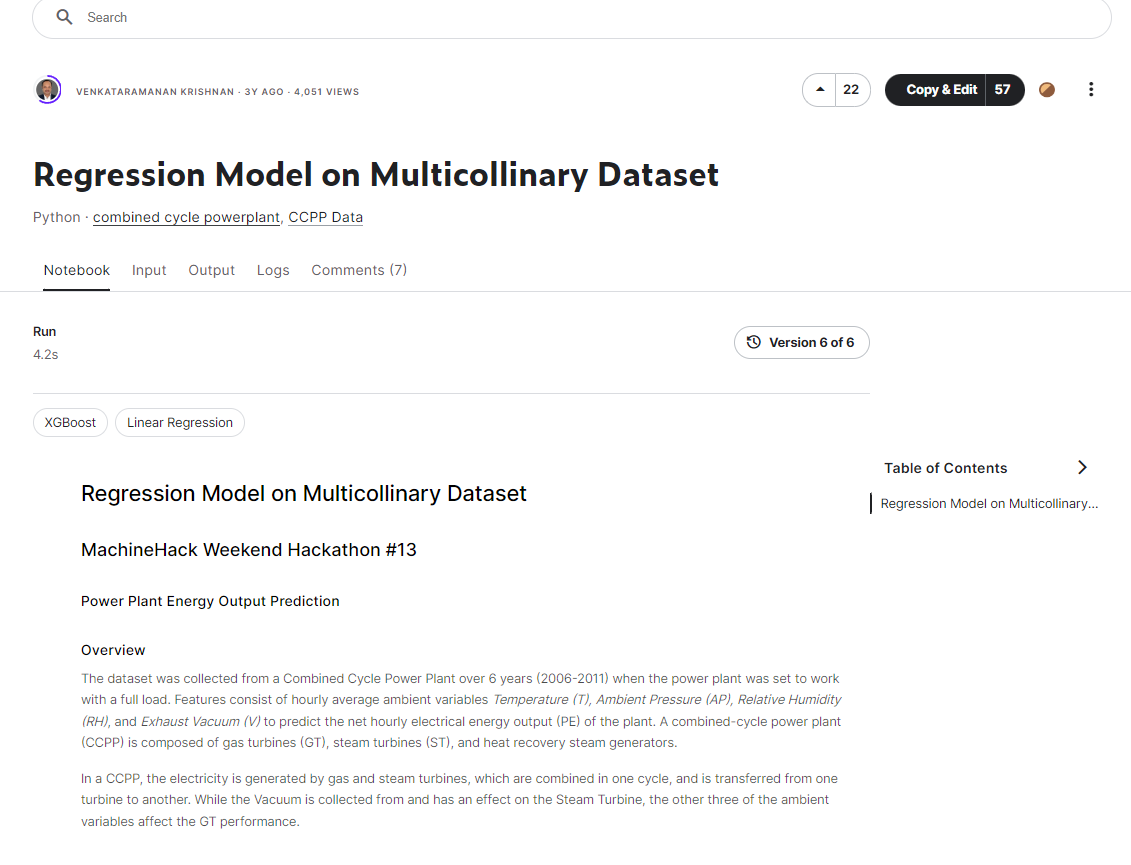

# ข้อสังเกตุ
* หากไม่กรองฝนอ่อนออกไป การสร้างโมเดลจะเกิดค่าฝนทำนายที่เป็นค่าน้อย ๆ ที่จะไปจับคู่กับฝนสถานีสสน.ที่เป็นค่าน้อย ทำให้แบบจำลองMLที่ได้มีปัญหา การ validate ได้ค่า R2 ต่ำ
* ควรทำการสกัดฝนมากกว่า 30 วัน ในช่วงมรสุม พายุ เพื่อให้ได้ค่าตัวอย่างมาสร้างโมเดลให้เพียงพอ
* เล่น K-fold for model selection > K-fold parameter tuning > Grid search approch for parameter tuning > Preprocess data pipeline (Standarscale)

* อ่าน K-fold https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/#:~:text=K%2Dfold%20cross%2Dvalidation%20is,estimate%20the%20model's%20generalization%20performance.

อ่าน K-fold https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/#:~:text=K%2Dfold%20cross%2Dvalidation%20is,estimate%20the%20model's%20generalization%20performance.
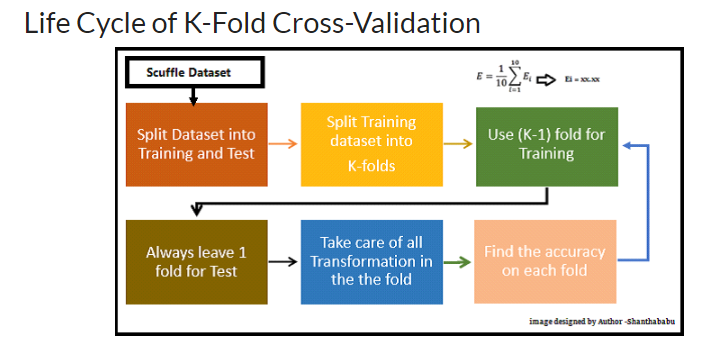

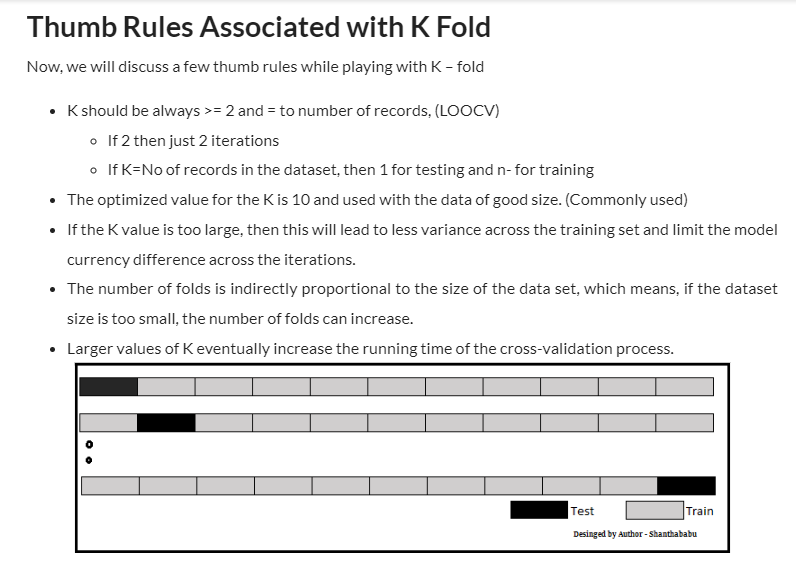

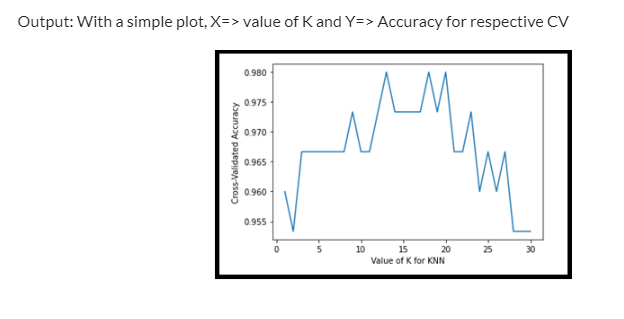


# เล่นการกับเลือก feature important 

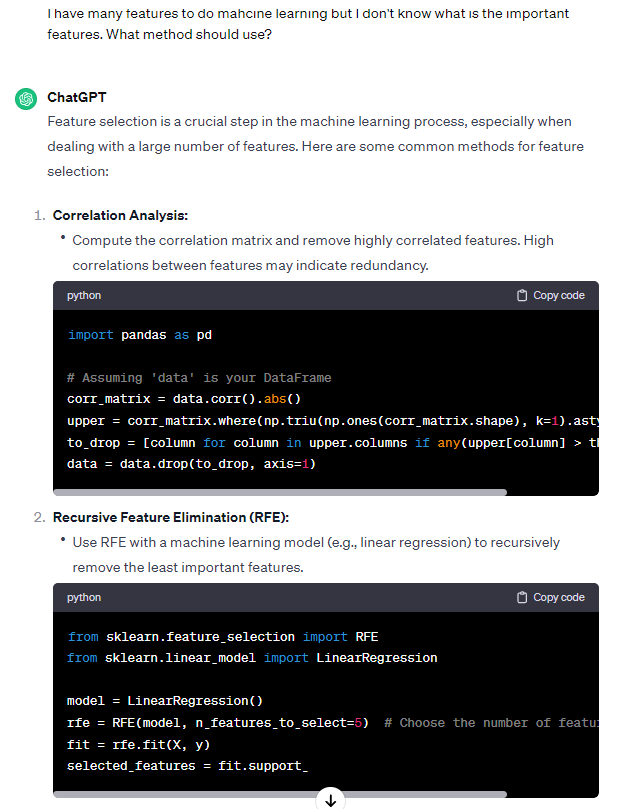

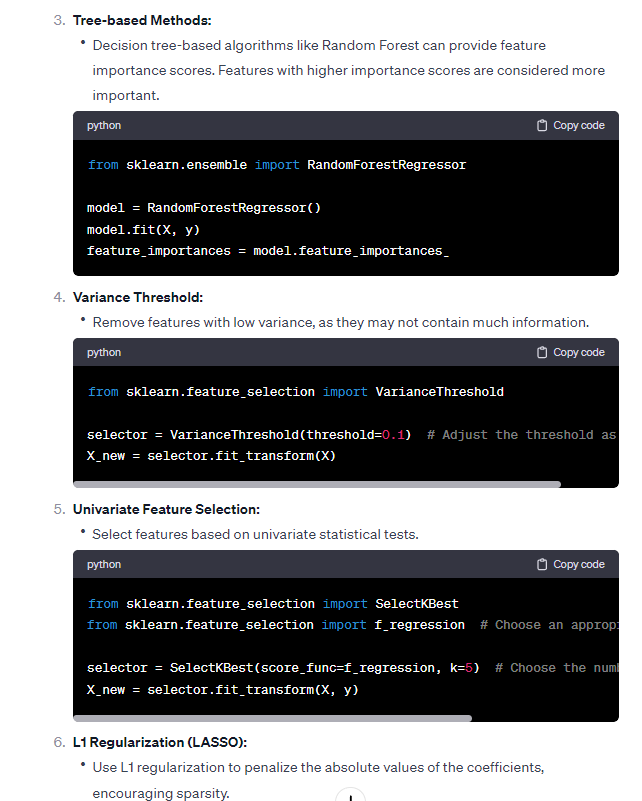

# เล่นกับ K-fold model selection

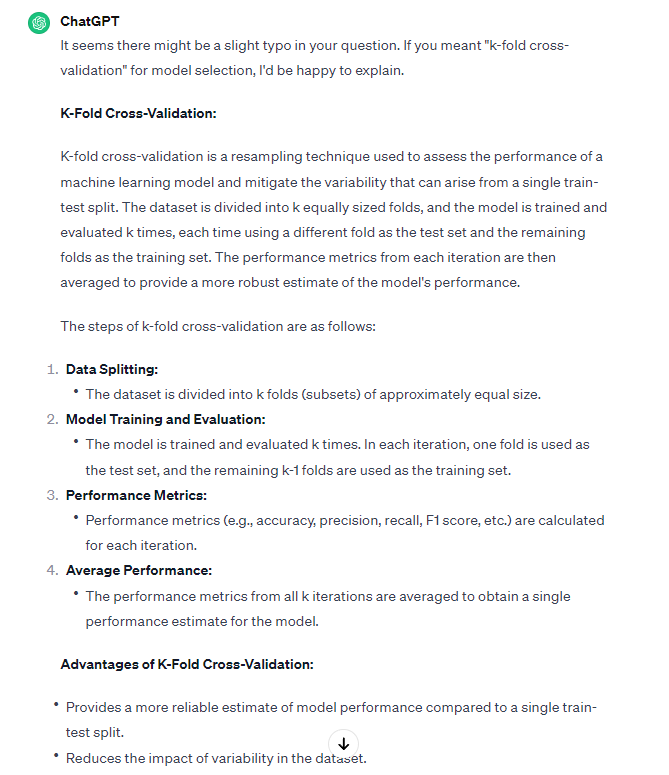

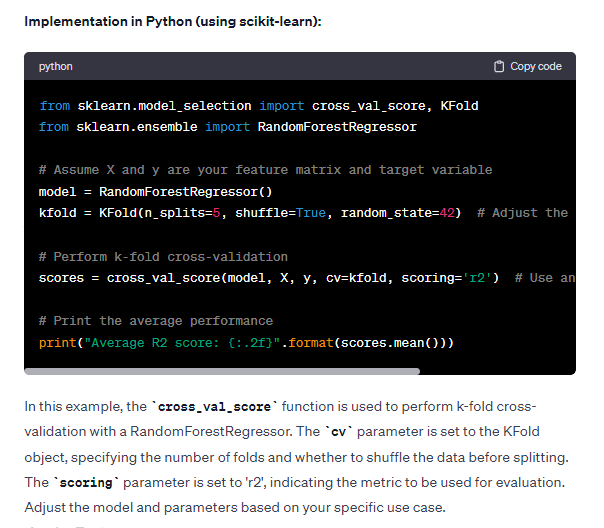


# เล่นกับแบบจำลอง multiple regression ด้วย machine learning ที่สำคัญ

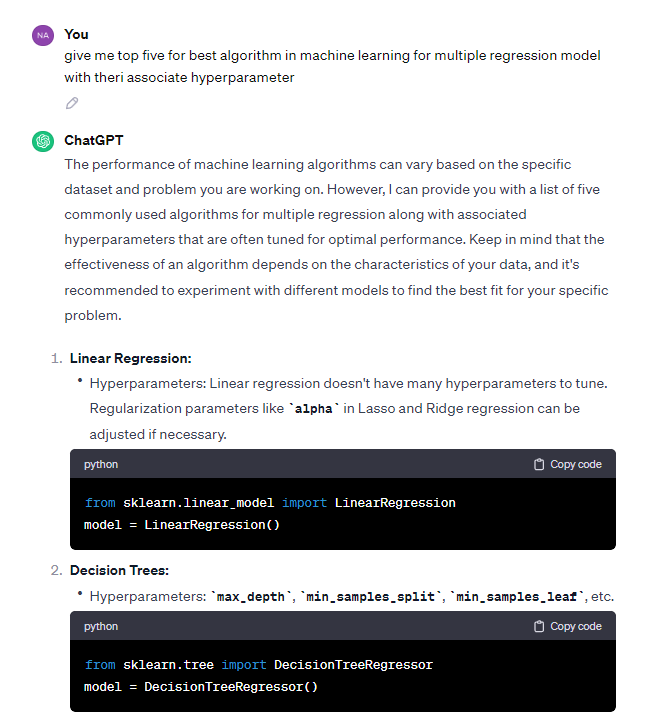

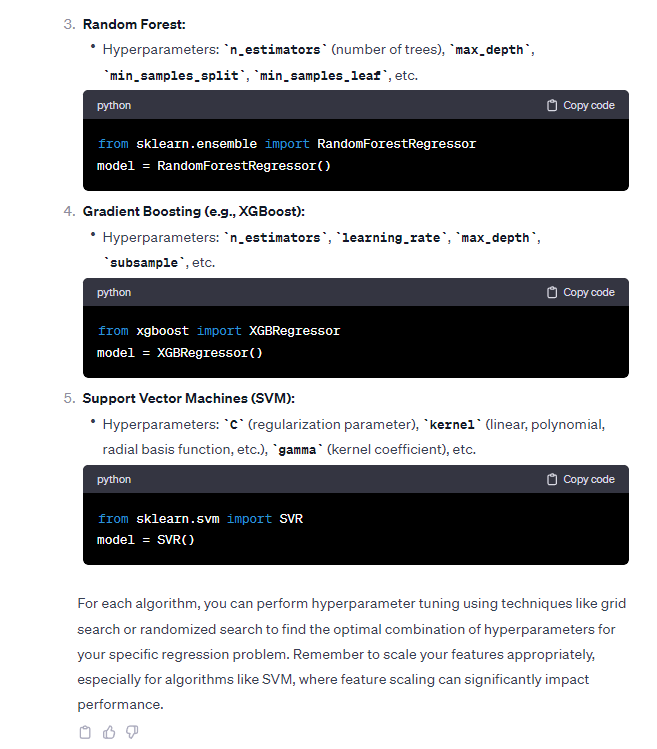